In [1]:
#author: Ashish Kumar
#creatig model for NTSB data for predicting safety index of a airplane
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
#read data and drop irrelvant data
aviation_df = pd.read_csv('./AviationData.csv',delimiter='|').drop(['Event Id','Investigation Type','Accident Number','Report Status','Publication Date'],axis=1)
aviation_df = aviation_df.drop(['Country','Registration Number','FAR Description','Unnamed: 31'],axis=1)

In [3]:
#simpley find total injuries and drop others and since no injury is reported 0 injury assumed
aviation_df['Total Injuries'] = aviation_df['Total Fatal Injuries']+aviation_df['Total Serious Injuries']+aviation_df['Total Minor Injuries']
aviation_df = aviation_df.drop(['Total Fatal Injuries','Total Serious Injuries','Total Minor Injuries','Total Uninjured'],axis=1)
aviation_df['Total Injuries'].fillna(0,inplace=True)

In [4]:
# Flight build amateurly should be unsafe : giving score of 1 for yes and no as 0.0
aviation_df.loc[aviation_df['Amateur Built'] == 'No' , ['Amateur Built']] = 0.0
aviation_df.loc[aviation_df['Amateur Built'] == 'Yes' , ['Amateur Built']] = 1.0

In [5]:
#model is only made for airplane not helicopters or gliders etc
aviation_df = aviation_df[aviation_df['Aircraft Category'] == 'Airplane']
#drop irrelevant data as its already taken care in other labels
aviation_df = aviation_df.drop([ 'Location','Airport Name','Injury Severity','Aircraft Damage','Aircraft Category','Schedule','Air Carrier','Model'],axis=1)


In [6]:
# Create map of accidents in US with injuries
aviation_ll_df =  aviation_df.filter(['Latitude','Longitude','Total Injuries'], axis=1)
aviation_ll_df.dropna(inplace=True)
lat = aviation_ll_df['Latitude'].values
lon = aviation_ll_df['Longitude'].values
aviation_ll_df['color'] = 'g'

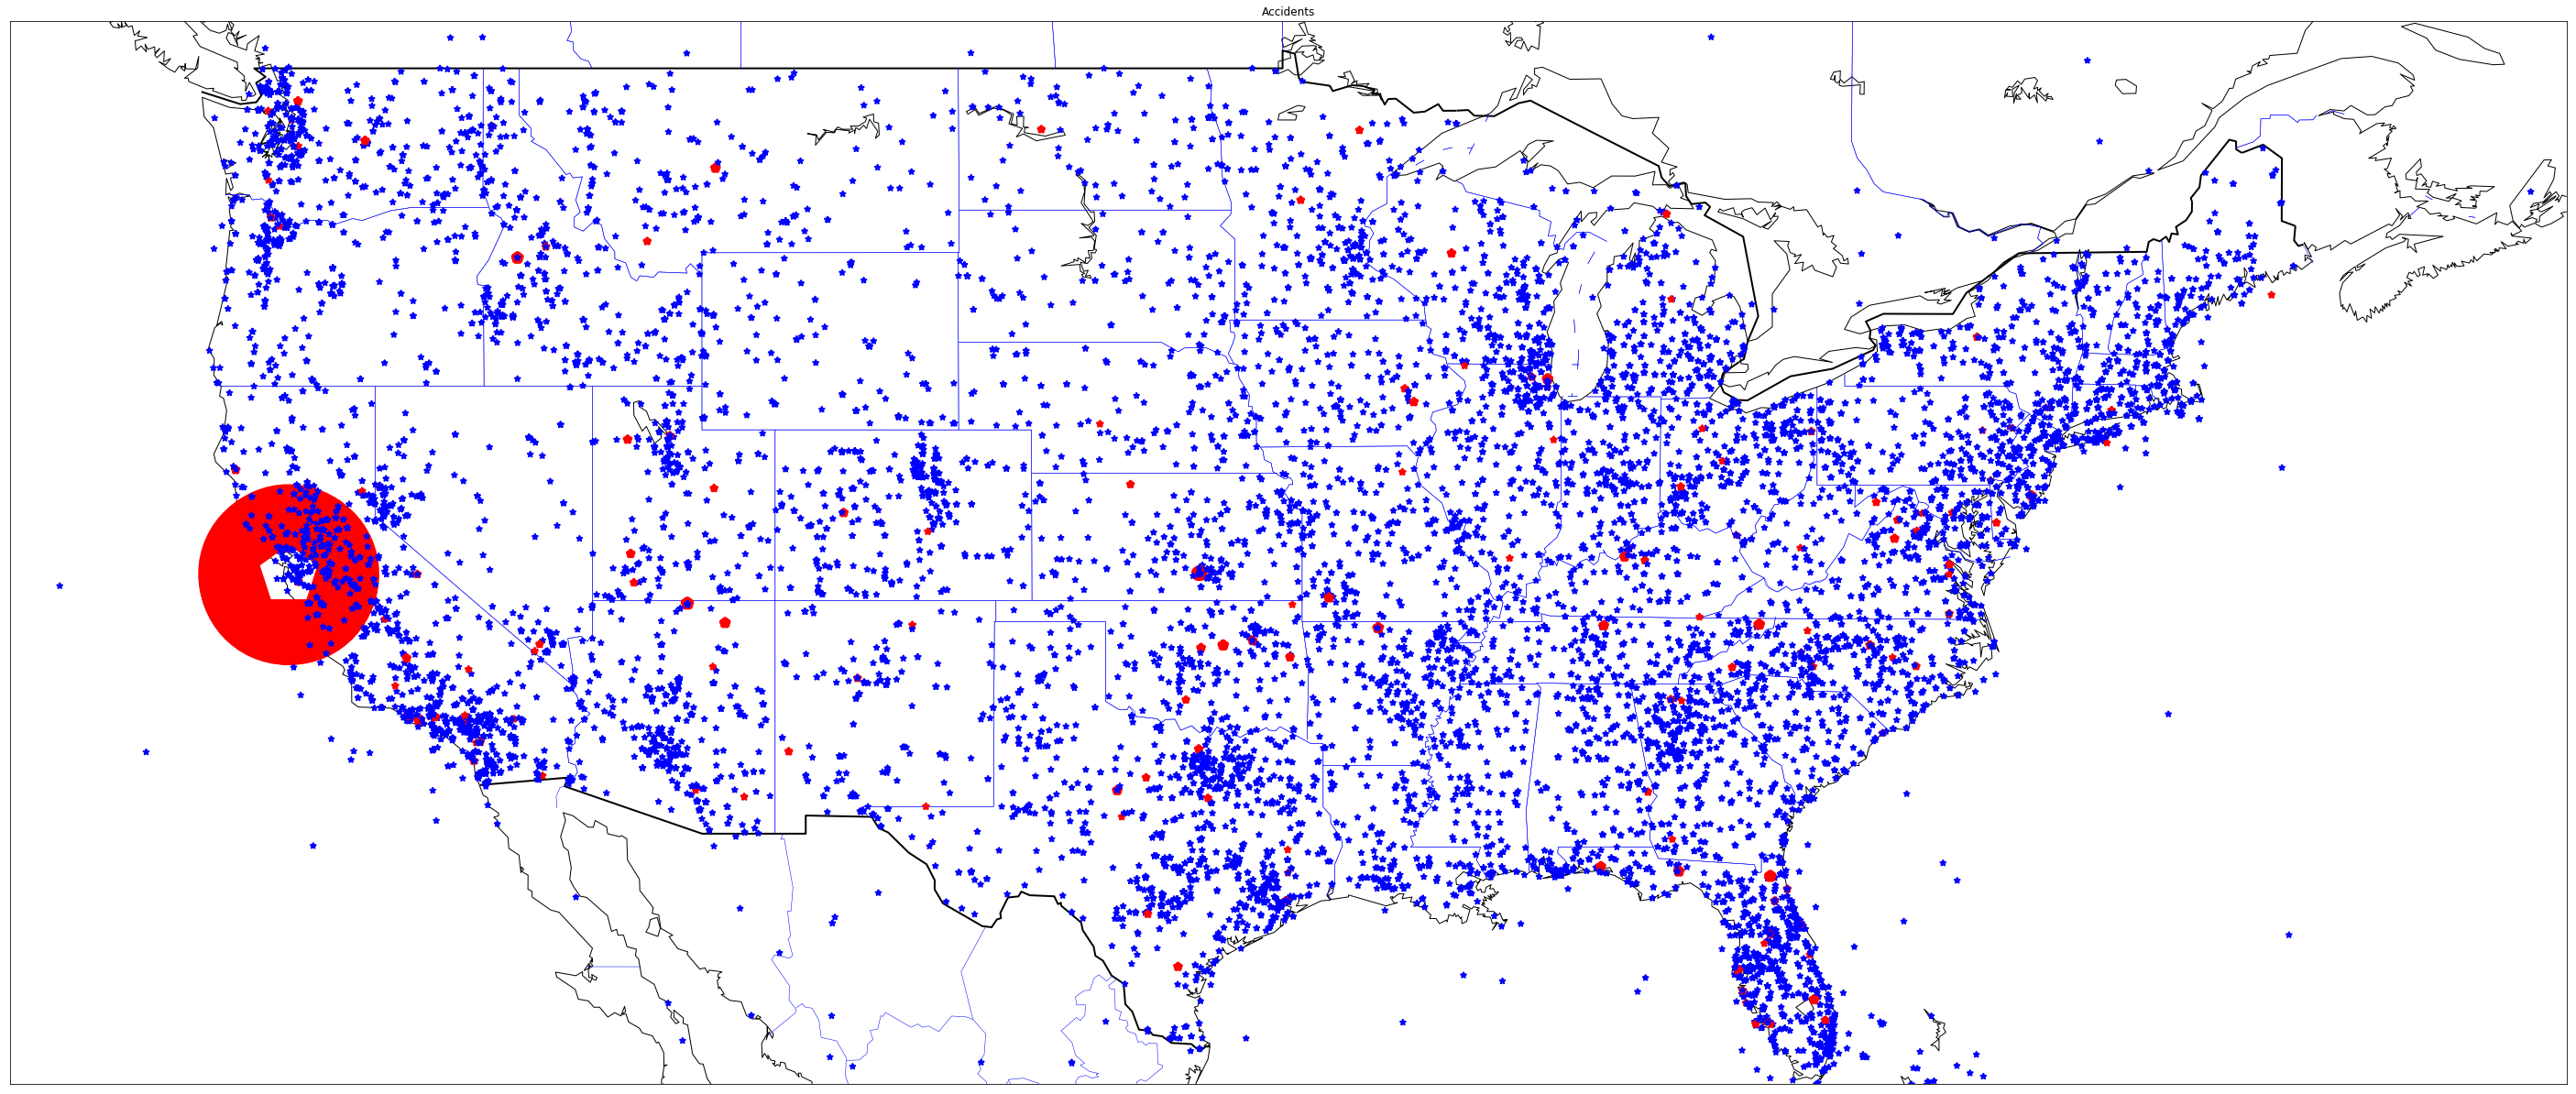

In [22]:
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='mill',llcrnrlat=25,llcrnrlon=-130,urcrnrlat=50,urcrnrlon=-60,resolution='l')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
lons, lats = m(lon,lat)
aviation_ll_df.loc[aviation_ll_df['Total Injuries'] == 0 , ['color']] = 'b'
aviation_ll_df.loc[aviation_ll_df['Total Injuries'] != 0 , ['color']] = 'r'
m.scatter(lons, lats, marker = '*', color=aviation_ll_df['color'], zorder=5,linewidth=aviation_ll_df['Total Injuries']+2)
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 50
fig_size[1] = 50
plt.rcParams["figure.figsize"] = fig_size
plt.title("Accidents")
plt.show()

In [8]:
#drop the coordinates and eventdate
aviation_df=aviation_df.drop(['Latitude','Longitude','Event Date'],axis=1)
aviation_df=aviation_df.dropna()

In [9]:
#assign score depending on number of occurances
for item in [ 'Make','Engine Type','Purpose of Flight','Weather Condition','Broad Phase of Flight','Airport Code']:
    aviation_df[item] = aviation_df[item].apply(lambda x: x.lower())
    df = aviation_df[item].value_counts()
    df=df/sum(df)
    df=df.reset_index()
    for i in range(len(df)):
        aviation_df.loc[aviation_df[item] == df['index'][i] , [item]] = df[item][i]

In [10]:
#same thing for int type
for item in ['Number of Engines']:
    #aviation_df[item] = aviation_df[item].apply(lambda x: x.lower())
    df = aviation_df[item].value_counts()
    df=df/sum(df)
    df=df.reset_index()
    for i in range(len(df)-1):
        aviation_df.loc[aviation_df[item] == df['index'][i] , [item]] = (len(df)-df['index'][i])/(len(df)-1)

aviation_df['Total Injuries'] = aviation_df['Total Injuries']/max(aviation_df['Total Injuries'])

In [11]:
#reset index
aviation_df = aviation_df.reset_index()
aviation_df = aviation_df.drop(['index'],axis=1)

In [12]:
for item in list(aviation_df):
    print(item, "\t\t\tmax = ", max(aviation_df[item]), "\t\t\tmin = ",min(aviation_df[item]))

Airport Code 			max =  0.022428330522765598 			min =  8.431703204047218e-05
Make 			max =  0.3472175379426644 			min =  8.431703204047218e-05
Amateur Built 			max =  1.0 			min =  0.0
Number of Engines 			max =  1.0 			min =  0.0
Engine Type 			max =  0.9365092748735244 			min =  8.431703204047218e-05
Purpose of Flight 			max =  0.6833895446880269 			min =  0.00016863406408094435
Weather Condition 			max =  0.9558178752107925 			min =  0.002023608768971332
Broad Phase of Flight 			max =  0.4323777403035413 			min =  0.0012647554806070826
Total Injuries 			max =  1.0 			min =  0.0


In [13]:
#base on value og max and min score : following score is arbitarlily defined
least_unsafe = 1.5
moderately_unsafe = 4.0
very_unsafe = 5.0

In [14]:
aviation_df['safety_score'] =  0.0
for item in ['Airport Code', 'Make', 'Amateur Built', 'Number of Engines', 'Engine Type', 'Purpose of Flight', 'Weather Condition', 'Broad Phase of Flight', 'Total Injuries']:
    aviation_df['safety_score'] = aviation_df['safety_score'] + aviation_df[item]
    

In [15]:
aviation_df['Safety_Index'] = aviation_df['safety_score']

In [16]:
#assign safety index based on score
aviation_df.loc[aviation_df['safety_score'] < least_unsafe , ['Safety_Index']] ='Least Unsafe'
aviation_df.loc[aviation_df['safety_score'] >= least_unsafe , ['Safety_Index']] = 'Moderately Unsafe'
aviation_df.loc[aviation_df['safety_score'] >= moderately_unsafe , ['Safety_Index']] ='Very Unsafe'
aviation_df.loc[aviation_df['safety_score'] >= very_unsafe , ['Safety_Index']] ='Most Unsafe'

In [19]:
#in the final model we dont need these two
aviation_df= aviation_df.drop(['safety_score','Total Injuries'],axis=1)

In [21]:
aviation_df.to_csv('aviation_model.csv')